<a href="https://colab.research.google.com/github/vytsb/Gilusis_Mokymas/blob/main/BookNLP_StableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# <img src="https://www.gutenberg.org/gutenberg/pg-logo-129x80.png" width=50 height=50>   <font color='Orange'>Book NLP 5 - <br> <b>Text</b>  to <b>Image</b> with Stable Diffusion</font>





---





In [20]:
#@title Imports

from google.colab import files
import pandas as pd
#import urllib.request
import os.path
import re

from google.colab.data_table import DataTable
DataTable.max_columns = 50

import numpy as np
import cv2
import os
import requests
import json

style_list =['Ultra realistic magic style',"Colorful cartoon drawing style", "anime art style", "Line drawing", "Coloring book page", "Salvador Dali", "A digital painting with an anime-inspired art style",
    "Detailed Renaissance style", "Surrealist painting", "Impressionist", "Abstract painting", "Pop Art painting", "Baroque-style", "Cubist painting", "Romantic painting",
    "Art Nouveau painting", "Gothic painting", "Macro photography", "Aerial photography", "Underwater photography", "Vintage-style travel photography", "Long-exposure night photography",
    "Documentary-style photography", "Photography with a shallow depth of field and soft lighting", "Cyberpunk with neon signs", "Fantasy illustration",
    "Digital painting", "Concept art", "Isometric digital art" , "Digital illustration in manga style", "Minimalistic digital artwork",
    "Sci-fi digital painting", "Steampunk digital art","Yamato-e","Kanō school","Gongbi","Shuimo","Literary painting",
    "Caricature drawing",  "Figure drawing", "Gesture drawing", "Scratchboard drawing", "Perspective drawing",
    "Photorealism", "Pointillism", "Scientific illustrations", "Silhouette drawing" , "Sketch drawing", "Technical drawing",
    "Vincent van Gogh", "Gustave Klimt", "M.C. Escher", "Claude Monet", "René Magritte", "Pablo Picasso",
    "Leonardo da Vinci", "Edvard Munch", "Andy Warhol",  "Pixel art"]





---

#  <font color='Blue'> 1. Mount the drive</font>  



In [21]:
from google.colab import drive

import os
if os.path.isdir('/content/drive/MyDrive'):
    print('Google Drive is mounted.')
else:
    drive.mount('/content/drive')


Mounted at /content/drive



---

#  <font color='Blue'> 2. Get prompts</font>  

In [22]:
style = style_list[0]
negative_prompt='distorted, ugly, deformed, disfigured, poor details' # grayscale,


## There are several ways to write a prompt.

>The first is to simply modify the JSON snippet below.

>Another way is to simply take this Prompt [Example_for_prompt](https://raw.githubusercontent.com/aalgirdas/novel-semantic-parsing/refs/heads/main/data/promt_for_scene_analysis.txt
), then add a TEXT part to it, then submit it to ChatGPT or Gemini and then replace the received response in place the JSON fragment below.

> The third way is to clean the JSON fragment and submit a .json file from the Internet instead.



In [23]:
prompt_response_json_text = """[
    {
        "scene_title": "Harry and Hermione in the Library",
        "description": "Harry Potter and Hermione Granger research information about Nicholas Flamel in the Hogwarts library.",
        "scene_type": "INT",
        "scene_date": "1991",
        "location": "Hogwarts Library",
        "time_of_day": "EVENING",
        "dialog_summary": "Harry and Hermione discuss the potential connection of Nicholas Flamel to the Philosopher's Stone while searching through books.",
        "characters": [
            "Harry Potter",
            "Hermione Granger"
        ],
        "objects": [
            "books",
            "scrolls",
            "wand",
            "candle",
            "chair",
            "desk"
        ],
        "object_part_of_object": [
            "cover;books",
            "pages;books",
            "wax;scrolls",
            "handle;wand",
            "flame;candle"
        ],
        "action_sequence": [
            "opened",
            "flipped through",
            "set down",
            "read aloud",
            "pointed",
            "whispered",
            "scanned",
            "lit"
        ],
        "text_phrases": [
            "scanning the dusty bookshelves",
            "whispering in hushed tones",
            "lit by the glow of a flickering candle",
            "flipping through pages with urgency",
            "Hermione read aloud from a thick tome",
            "Harry pointed at a passage excitedly"
        ]
    }
]

"""

In [24]:
#@title If the prompt_response_json_text variable is an empty string then the json file from the Internet must be submitted

if len(prompt_response_json_text)==0:
  book_code = '2852' # 84  244 2701 2852 42671
  url = "https://raw.githubusercontent.com/aalgirdas/novel-semantic-parsing/refs/heads/main/data/gpt4_scene_info_"+book_code+".json"
  response = requests.get(url)
  prompt_response_json_text = response.text
else:
  prompt_response_json_text = '{"1":'+prompt_response_json_text+'}'

In [25]:
data = json.loads(prompt_response_json_text)
print("JSON data:", data)


JSON data: {'1': [{'scene_title': 'Harry and Hermione in the Library', 'description': 'Harry Potter and Hermione Granger research information about Nicholas Flamel in the Hogwarts library.', 'scene_type': 'INT', 'scene_date': '1991', 'location': 'Hogwarts Library', 'time_of_day': 'EVENING', 'dialog_summary': "Harry and Hermione discuss the potential connection of Nicholas Flamel to the Philosopher's Stone while searching through books.", 'characters': ['Harry Potter', 'Hermione Granger'], 'objects': ['books', 'scrolls', 'wand', 'candle', 'chair', 'desk'], 'object_part_of_object': ['cover;books', 'pages;books', 'wax;scrolls', 'handle;wand', 'flame;candle'], 'action_sequence': ['opened', 'flipped through', 'set down', 'read aloud', 'pointed', 'whispered', 'scanned', 'lit'], 'text_phrases': ['scanning the dusty bookshelves', 'whispering in hushed tones', 'lit by the glow of a flickering candle', 'flipping through pages with urgency', 'Hermione read aloud from a thick tome', 'Harry pointed

In [26]:
number_of_prompts = 10 #+1000

scene_nr = 1
prompts = []
scene_dates = []
scene_locations = []
scene_objects = []
for key, value in data.items():
  for item in value:
    print(f"{scene_nr:>5} {item.get('description')}")
    prompts.append(item.get('description'))
    scene_dates.append(item.get('scene_date'))
    scene_locations.append(item.get('location'))
    scene_objects.append(item.get('objects'))
    scene_nr += 1

  if scene_nr > number_of_prompts:
    break

    1 Harry Potter and Hermione Granger research information about Nicholas Flamel in the Hogwarts library.


---

#  <font color='Blue'>🔗 Diffusers</font>  

In [27]:
%pip install --quiet --upgrade diffusers transformers accelerate mediapy peft

In [28]:
%%capture
import mediapy as media
import random
import sys
import torch

from diffusers import DiffusionPipeline, TCDScheduler
from huggingface_hub import hf_hub_download

# Choose either 8 or 12 steps:
num_inference_steps = 12

base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
repo_name = "ByteDance/Hyper-SD"
plural = "s" if num_inference_steps > 1 else ""
ckpt_name = f"Hyper-SDXL-{num_inference_steps}step{plural}-CFG-lora.safetensors"
device = "cuda"

pipe = DiffusionPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16, variant="fp16").to(device)
pipe.load_lora_weights(hf_hub_download(repo_name, ckpt_name))
pipe.fuse_lora()
pipe.scheduler = TCDScheduler.from_config(pipe.scheduler.config)

0    1991. Location is Hogwarts Library. Objects: books, scrolls, wand, candle, chair, desk. Ultra realistic magic style. Harry Potter and Hermione Granger research information about Nicholas Flamel in the Hogwarts library. 


  0%|          | 0/12 [00:00<?, ?it/s]

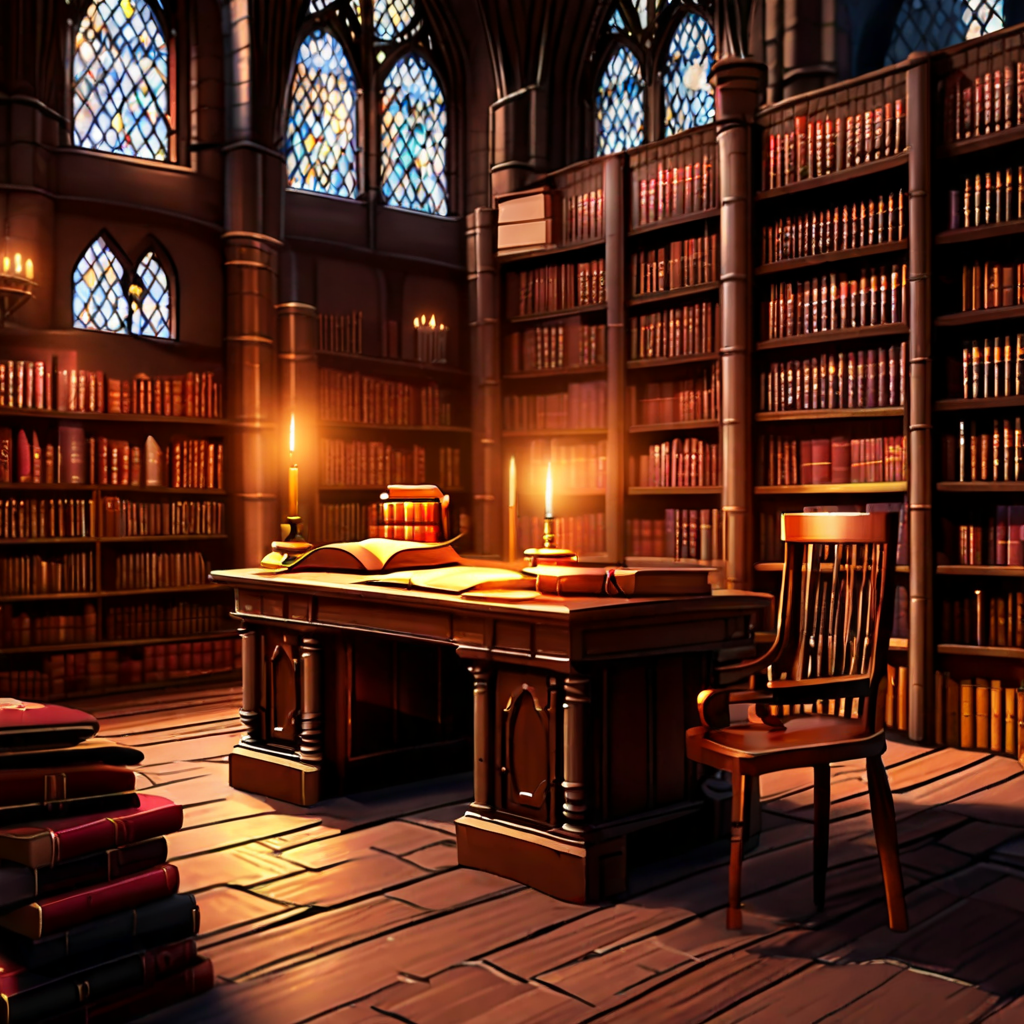

In [29]:
seed = random.randint(0, sys.maxsize)
guidance_scale = 5.0 ## Pick a value between 5.0 and 8.0:
eta = 0.1 # # Decrease eta (min: 0, max: 1.0) to get more details with multi-step inference:


all_images_list = []
for image_nr, prompt in enumerate(prompts):
        #images = model.text_to_image(style  + ' ' +prompt, batch_size=1)

        if 'scene_dates' in globals():
          prompt = scene_dates[image_nr]  + ". Location is "+scene_locations[image_nr]+". Objects: " + (", ".join(scene_objects[image_nr]))+ ". " + style + ". "  + prompt
        print(f'{image_nr}    {prompt} ')
        images = pipe( prompt = prompt,  num_inference_steps = num_inference_steps ,  guidance_scale = guidance_scale,   eta = eta,    generator = torch.Generator(device).manual_seed(seed),  negative_prompt=negative_prompt   ).images
        image_info_tuple = (image_nr, prompt, images[0]  )
        all_images_list.append(image_info_tuple)
        #break

all_images_list[0][2]

In [30]:

image_list = [np.array(img[2]) for img in all_images_list]

In [31]:


def save_images(image_list, directory):

    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, image in enumerate(image_list):
        filename = f"image_{i}.jpg"  # Adjust the filename format as needed
        filepath = os.path.join(directory, filename)
        cv2.imwrite(filepath, image)


directory = "saved_images"

save_images(image_list, directory)

!zip -r saved_images.zip saved_images
!cp saved_images.zip /content/drive/MyDrive/saved_images.zip

updating: saved_images/ (stored 0%)
updating: saved_images/image_0.jpg (deflated 0%)



---

#  <font color='Blue'>🎬 Let's try to put all the images into a video file with audio track </font>  

In [32]:
!pip install gTTS -q

In [33]:
'''
# Import the required module for text
# to speech conversion
from gtts import gTTS

# This module is imported so that we can
# play the converted audio
import os

# The text that you want to convert to audio
mytext = 'Welcome to geeksforgeeks Joe!'

# Language in which you want to convert
language = 'en'

# Passing the text and language to the engine,
# here we have marked slow=False. Which tells
# the module that the converted audio should
# have a high speed
myobj = gTTS(text=mytext, lang=language, slow=False)

# Saving the converted audio in a mp3 file named
# welcome
myobj.save("welcome.mp3")
'''

'\n# Import the required module for text\n# to speech conversion\nfrom gtts import gTTS\n\n# This module is imported so that we can\n# play the converted audio\nimport os\n\n# The text that you want to convert to audio\nmytext = \'Welcome to geeksforgeeks Joe!\'\n\n# Language in which you want to convert\nlanguage = \'en\'\n\n# Passing the text and language to the engine,\n# here we have marked slow=False. Which tells\n# the module that the converted audio should\n# have a high speed\nmyobj = gTTS(text=mytext, lang=language, slow=False)\n\n# Saving the converted audio in a mp3 file named\n# welcome\nmyobj.save("welcome.mp3")\n'

In [34]:
from gtts import gTTS

mp3_list = []
for image_nr, prompt in enumerate(prompts):
  mytext = prompt
  myobj = gTTS(text=mytext, lang='en', slow=False, tld='co.uk')  # https://gtts.readthedocs.io/en/latest/module.html#gtts.tts.gTTS
  myobj.save("welcome"+str(image_nr)+".mp3")
  mp3_list.append("welcome"+str(image_nr)+".mp3")
  print(f'{image_nr} ', end='')



0 

In [35]:
!pip install -q moviepy pillow

In [36]:
import numpy as np
from PIL import Image
from moviepy.editor import ImageSequenceClip, AudioFileClip, concatenate_videoclips

frames = [np.array(img) for img in image_list] # images to numpy arrays

video_clips = []
for i, frame in enumerate(frames):
    audio_clip = AudioFileClip(mp3_list[i])

    ##img_clip = ImageSequenceClip([frame], fps=1)  # 1 frame per second
    img_clip = ImageSequenceClip([frame], durations=[audio_clip.duration])  # 1 frame per second

    #img_clip = img_clip.set_duration(audio_clip.duration)  # Set the duration of the image clip to match the audio clip

    img_clip = img_clip.set_audio(audio_clip)

    video_clips.append(img_clip)

final_clip = concatenate_videoclips(video_clips)

final_clip.write_videofile("output_video_with_audio.mp4", codec="libx264",fps=1)

Moviepy - Building video output_video_with_audio.mp4.
MoviePy - Writing audio in output_video_with_audioTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output_video_with_audio.mp4



Moviepy - Done !
Moviepy - video ready output_video_with_audio.mp4


#